# Deep Learning Models

### Transformer Introduction

Transformer is a building block for the Large Language models such as Bert, Roberta etc. Transformer attempted to resolve inherited issues of RNN-based models, such as slower computations and vanishing gradients, and Difficulty in accessing long previous states (LSTM attempted to resolve this issue). Transformed attempted to resolve these issues with the help of encoders and decoders. Encoder/Decoders both are of similar nature, with the stack modules placed one over other.

It is based on multi-head attention and feed-forward layers. Self-attention is a mechanism in which words capture not just the meaning (given by input embedding) or position in a sentence (represented via positional encoding) but also each word's interaction with the other words in a sentence. To capture the attention between smaller components, multi-head attention divides the input into multiple smaller components based on a size (referred to as dmodel). The results are then concatenated to get the multi-head attention (Jamil, 2023). The mechanism is slightly different at the decoder side of the model, where the decoder performs masked multi-head attention instead of multi-head attention on the input. This involves cross-attention between the input from the encoder and the query from the output embedding layer.

LSTMs and Transformers can handle variable-length sequences and perform training over multiple time steps. The key difference between LSTMs and Transformers is their approach to managing long-range dependencies. LSTMs apply a recurrent structure to process elements sequentially and update their hidden state after each time step based on the current input and the previous hidden state. In contrast, Transformers utilise self-attention to calculate a weighted sum across all input elements, enabling them to capture dependencies between any two elements in the sequence, regardless of their distance apart.


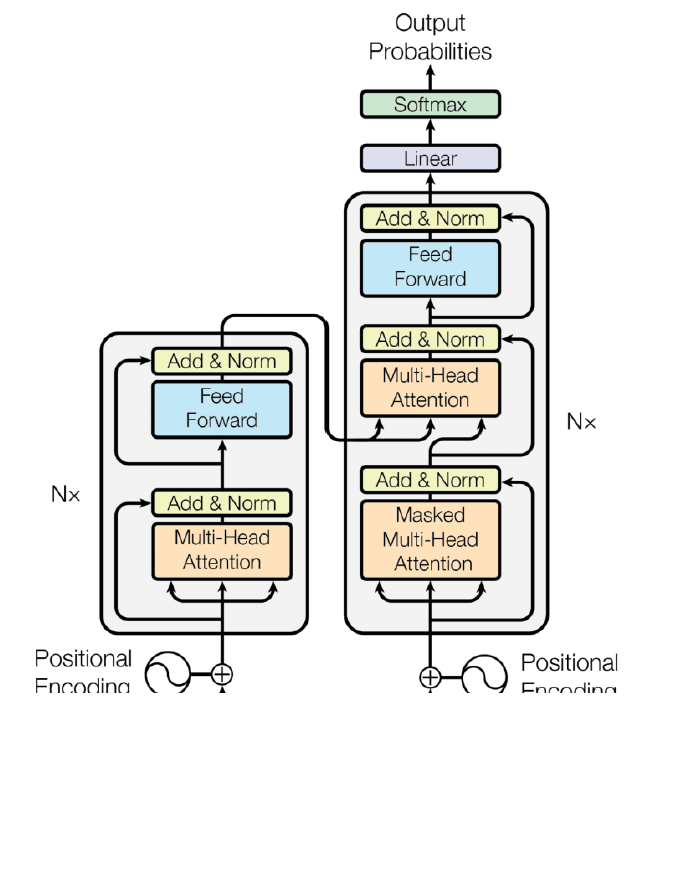

## Transfer Learning (For Fine Tunning)

Transfer learning is a type of machine learning where a model that was trained for one task is used again for a different task. This can be achieved either by fine-tuning the model's parameters on the new task, or by using the model's features as a starting point for training a new model. Transfer learning has the potential to be a highly efficient means of augmenting the performance of machine learning models on novel tasks, particularly in the event of limited data availability for the new task.
Examples of transfer learning are:



*   A model trained to classify images of cats and dogs can be reused to classify images of other animals.
*   A model trained to translate text from English to French can be reused to translate text from English to Spanish.
*   A model trained to predict customer churn can be reused to predict employee turnover.

Transfer learning helps to improve the performance of models on new tasks, even when there is limited data is available. The approach for the transfer learning could be classified into four broad categories :


**Instances-based**
Use of instances in the source domain by giving them the right weight. The idea is to assign appropriate weights to the source instances based on relevancy or similarity to the target domain in order to have importance towards instances that are more relevant to the target domain, assisting in the adaptation process.

**Mapping-based**
Mapping instances from two domains into a new data space with better similarity. This bridge the gap between two domains by finding a transformation that aligns their representations in the new space.

**Network-based**
Reuse is the part of the network that was trained in the source domain. The pre-trained network might have learned the features that could be relevant to the target domain.

**Adversarial-based**
Use adversarial technology to find transferable features that are suitable for two domains. The main model attempts to confuse the adversarial network by producing domain-invariant features by distinguishing between instances from the source and target domains.


Benefits of transfer learning are:


1.   Less training time required because generally weights are not randomized resulting in lesser training time.
2.   It results in having an improved performance because the model is trained using task specific knowledge.
3.   It could be trained on lesser data due to the reason that these models are already pre trained on extensive dataset sources.















## Importing the Required Libraries

Downloading the required libraries for the LLM Fine-Tunning

In [3]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch', 'transformers', 'datasets', 'tensorflow'])
except ImportError:
    pass

In [4]:
import numpy as np
import pandas as pd
import transformers
import torch
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

#Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast, TFBertModel, AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW

# Display Libraries
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

# specify GPU
device = torch.device("cuda")

# Loading datasets and Splitting

### 1. Loading the dataset

Cleaned data extratced after preprocessing the text is loaded for the purpose of neural deep LSTM based model.</p>

In [5]:
cleaned_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv')

In [6]:
cleaned_df

,label,title_text
0,true,national federation independent business
1,true,comment fayetteville nc
2,true,romney make pitch hope close deal election roc...
3,true,democratic leader say house democrats united g...
4,true,budget united states government fy
...,...,...
60731,fake,white house theatrics gun control 21st century...
60732,fake,activist terrorist medium control dictate narr...
60733,fake,boiler room surrender retreat head roll ep tun...
60734,fake,federal showdown looms oregon blm abuse local ...


In [7]:
cleaned_df['id'] = cleaned_df['label'].replace({'fake': 0, 'true': 1})

In [8]:
cleaned_df['title_text'] = cleaned_df['title_text'].astype(str)

In [9]:
cleaned_df

,label,title_text,id
0,true,national federation independent business,1
1,true,comment fayetteville nc,1
2,true,romney make pitch hope close deal election roc...,1
3,true,democratic leader say house democrats united g...,1
4,true,budget united states government fy,1
...,...,...,...
60731,fake,white house theatrics gun control 21st century...,0
60732,fake,activist terrorist medium control dictate narr...,0
60733,fake,boiler room surrender retreat head roll ep tun...,0
60734,fake,federal showdown looms oregon blm abuse local ...,0


## Split data into Training and Testing [Training: 80%, Testing:20%]

 Dataset is splitted into X_train, X_test, y_train, y_test using Sk-Learn library with the ratio 80% - Training and 20% Testing.</p>

In [10]:
# Dataset is getting splitted with a ratio of 70:15:15
# Stratify kept to ensure that split is same class distribution (Though, our dataset is balanced but this is beneficial where dataset is imbalance).
X_train, X_test_temp, y_train, y_test_temp = train_test_split(cleaned_df['title_text'], cleaned_df['id'], test_size=0.3, shuffle=True, random_state=42,stratify=cleaned_df['label'])


# Validation-Test split
X_test, X_val, y_test, y_val = train_test_split(X_test_temp, y_test_temp, random_state=42, test_size=0.5, stratify=y_test_temp)

In [11]:
# To release the memory allocated to GPU before runing the deep learning
from numba import cuda

device = cuda.get_current_device();
device.reset()

In [12]:
# To release the memory allocated to GPU before runing the deep learning
torch.cuda.empty_cache()

In [13]:
#Defining the device to be used on the based on available resources
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Model Preparation and Training (Pytorch)

## Loading pretrained model

In [14]:
# Loading Model from Hugging Face
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



*   We can notice that most articles has polarity of almost 0 neither being sad nor happy.
*   Text length for the news is around 0-5000 characters.
*   Wrod count is in between 0-1000 words.



In [15]:
# BERT Tokeizer Functionality
sample_data = ["I am in love with NLP.",
               "LLM's like bert are very good."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

{'input_ids': [[101, 1045, 2572, 1999, 2293, 2007, 17953, 2361, 1012, 102, 0, 0], [101, 2222, 2213, 1005, 1055, 2066, 14324, 2024, 2200, 2204, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Tokenzing the traning, validation and test datasets

In [16]:
MAX_LENGHT = 500

# Tokenize and encode sequences in the train dataset
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = MAX_LENGHT,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the validation dataset
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = MAX_LENGHT,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the test dataset
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = MAX_LENGHT,
    padding='max_length',
    truncation=True
)

Get the list of tensor for sequence , mask and y labels.

In [17]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [18]:
print(train_seq.shape)
print(train_mask.shape)
print(train_y.shape)

print(val_seq.shape)
print(val_mask.shape)
print(val_y.shape)


torch.Size([42515, 300])
torch.Size([42515, 300])
torch.Size([42515])
torch.Size([9111, 300])
torch.Size([9111, 300])
torch.Size([9111])


In [19]:
# Tensor Datasets are created for the purpose of model training and validation
# batch size for training and validation
batch_size = 32

# Create a TensorDataset for the training data
train_data = TensorDataset(train_seq, train_mask, train_y)
# Randomly sample data during training (shuffling)
train_sampler = RandomSampler(train_data)
# Create a DataLoader for training, providing data in batches
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create a TensorDataset for the validation data
val_data = TensorDataset(val_seq, val_mask, val_y)
# Sequentially sample data during validation (no shuffling)
val_sampler = SequentialSampler(val_data)
# Create a DataLoader for validation, providing data in batches
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [20]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [21]:
class BERT_Tuning(nn.Module):
    def __init__(self, bert_model):
        super(BERT_Tuning, self).__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(0.1)  # Dropout layer
        self.relu = nn.ReLU()           # ReLU activation function (for hidden layer)
        self.fc1 = nn.Linear(768, 512)  # Dense layer 1 (based on Bert 12 layers each having 768 hidden units)
        self.fc2 = nn.Linear(512, 2)    # Dense layer 2 (Output 2 layers for Binary classification)
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax activation function (for output layer)

    def forward(self, sent_id, mask):
        """
        Forward pass of the model.

        Args:
        - sent_id (tensor): Input sentence IDs.
        - mask (tensor): Attention mask.

        Returns:
        - x (tensor): Output probabilities.
        """

        cls_hs = self.bert_model(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Create an instance of the BERT_Tuning class with the pre-trained BERT model
model = BERT_Tuning(bert)
model = model.to(device)

# Define hyperparameters (optimizer (Adam Optimization - good for Bert), loss function, and number of training epochs)
optimizer = AdamW(model.parameters(), lr=1e-5)  # Learning rate
cross_entropy = nn.NLLLoss()                    # Loss function (Negative Log Likelihood Loss)
epochs = 15                                      # Number of training epochs


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Model Training

In [22]:
### Define Train Function
def train():
    # Set the model in training mode
    model.train()
    # Initialize variables to keep track of total loss and accuracy
    total_loss, total_accuracy = 0, 0

    # Iterate over batches in the training dataloader
    for step, batch in enumerate(train_dataloader):
        # Print progress update every 50 batches
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # Extract input data (sentence IDs, mask) and labels from the batch
        sent_id, mask, labels = batch
        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)
        # Clear previously calculated gradients
        model.zero_grad()

        # Get model predictions for the current batch
        preds = model(sent_id, mask)

        # Compute the loss between predictions and actual labels
        loss = cross_entropy(preds, labels)

        # Accumulate the loss for later calculation of the average loss
        total_loss = total_loss + loss.item()

        # Backpropagate to calculate gradients
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update model parameters using the optimizer
        optimizer.step()

        # Move predictions to CPU and convert to NumPy array
        preds = preds.detach().cpu().numpy()

    # Calculate the average loss for the entire training dataset
    avg_loss = total_loss / len(train_dataloader)

    # Return the average loss
    return avg_loss

### Define Evaluate Function
def evaluate():
    # Set the model in evaluation mode
    model.eval()
    # Initialize variables to keep track of total loss and accuracy
    total_loss, total_accuracy = 0, 0

    # Iterate over batches in the validation dataloader
    for step, batch in enumerate(val_dataloader):
        # Print progress update every 50 batches
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # Extract input data (sentence IDs, mask) and labels from the batch
        sent_id, mask, labels = batch

        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)

        # Disable gradient computation for evaluation
        with torch.no_grad():
            # Get model predictions for the current batch
            preds = model(sent_id, mask)

            # Compute the loss between predictions and actual labels
            loss = cross_entropy(preds, labels)

            # Accumulate the loss for later calculation of the average loss
            total_loss = total_loss + loss.item()

            # Move predictions to CPU and convert to NumPy array
            preds = preds.detach().cpu().numpy()

    # Calculate the average loss for the entire validation dataset
    avg_loss = total_loss / len(val_dataloader)

    # Return the average loss
    return avg_loss


In [23]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

Using GPU: Tesla V100-SXM2-16GB


In [28]:
best_valid_loss = float('inf')  # Initialize a variable to store the best validation loss, set to positive infinity
train_losses = []               # Initialize an empty list to store training losses for each epoch
valid_losses = []               # Initialize an empty list to store validation losses for each epoch

# Loop through the specified number of training epochs
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))  # Print the current epoch number

    # Train the model for one epoch and calculate the training loss
    train_loss = train()

    # Evaluate the model on the validation dataset and calculate the validation loss
    valid_loss = evaluate()

    # Check if the current validation loss is better (lower) than the best validation loss seen so far
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss  # Update the best validation loss
        destination_path = '/content/drive/MyDrive/MyModels/'
        torch.save(model.state_dict(), destination_path + 'c3_new_model_weights.pt')  # Save the model's weights

        # Save the entire model (architecture and weights)
        torch.save(model, destination_path + 'c3_new_entire_model.pt')

    # Append the training and validation losses to their respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print the training and validation losses for the current epoch
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')




 Epoch 1 / 15
  Batch    50  of  1,329.
  Batch   100  of  1,329.
  Batch   150  of  1,329.
  Batch   200  of  1,329.
  Batch   250  of  1,329.
  Batch   300  of  1,329.
  Batch   350  of  1,329.
  Batch   400  of  1,329.
  Batch   450  of  1,329.
  Batch   500  of  1,329.
  Batch   550  of  1,329.
  Batch   600  of  1,329.
  Batch   650  of  1,329.
  Batch   700  of  1,329.
  Batch   750  of  1,329.
  Batch   800  of  1,329.
  Batch   850  of  1,329.
  Batch   900  of  1,329.
  Batch   950  of  1,329.
  Batch 1,000  of  1,329.
  Batch 1,050  of  1,329.
  Batch 1,100  of  1,329.
  Batch 1,150  of  1,329.
  Batch 1,200  of  1,329.
  Batch 1,250  of  1,329.
  Batch 1,300  of  1,329.
  Batch    50  of    285.
  Batch   100  of    285.
  Batch   150  of    285.
  Batch   200  of    285.
  Batch   250  of    285.

Training Loss: 0.540
Validation Loss: 0.490

 Epoch 2 / 15
  Batch    50  of  1,329.
  Batch   100  of  1,329.
  Batch   150  of  1,329.
  Batch   200  of  1,329.
  Batch   250  

C1=>

C2=>
Text Length = 200
Epoches = 10
Batch Size = 16

C3=>
Text Length = 300
Epoches = 15
Batch Size = 32

In [29]:
# load weights of best model

path = '/content/drive/MyDrive/MyModels/c3_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [30]:
# Initialize an empty list to collect batch predictions
all_preds = []

batch_size = 16

for i in range(0, len(test_seq), batch_size):
    batch_seq = test_seq[i:i+batch_size].to('cuda:0')
    batch_mask = test_mask[i:i+batch_size].to('cuda:0')

    # Perform inference on the current batch
    with torch.no_grad():
      preds_batch = model(batch_seq, batch_mask)
      # print(preds_batch)

    # Convert the predictions to numpy and append to the list
      preds_batch = preds_batch.detach().cpu().numpy()
      # print(preds_batch)
      all_preds.append(preds_batch)

# Concatenate the list of batch predictions into a single numpy array
y_pred = np.concatenate(all_preds, axis=0)

In [31]:
# Obtain predicted class labels (0 or 1) from probabilities
y_pred = np.argmax(y_pred, axis = 1)
# y_pred


In [32]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78      3462
           1       0.83      0.96      0.89      5648

    accuracy                           0.85      9110
   macro avg       0.87      0.82      0.83      9110
weighted avg       0.86      0.85      0.85      9110



<Figure size 1500x1500 with 0 Axes>

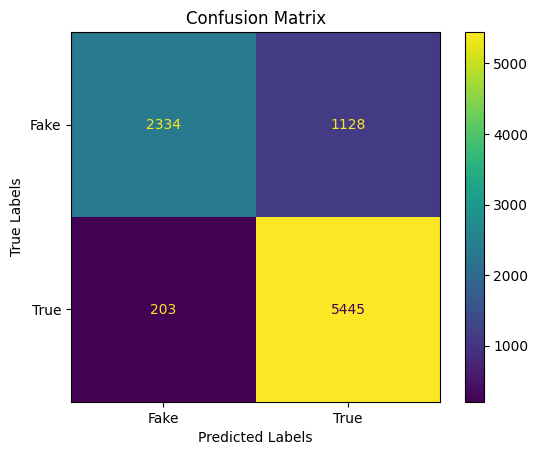

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round the predicted probabilities to get predicted classes (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
# Display labels
display_labels = ['Fake', 'True']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
plt.gcf().set_size_inches(15, 15)
disp.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y,y_pred)

0.8538968166849615

In [35]:
from sklearn.metrics import classification_report

print("Classification Report:\n",classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78      3462
           1       0.83      0.96      0.89      5648

    accuracy                           0.85      9110
   macro avg       0.87      0.82      0.83      9110
weighted avg       0.86      0.85      0.85      9110



**Conclusion :** We can clearly notice that probabilies are quite low by our model. This might be because `bloomz-1b1` might not have been trained on classification task espcially fake news. `ZeroShotClassifier` and `FewShotClassifer` heavily relies on the pre trained data quality, therefore, there is possibility that it might not run on low level distiction between different categories.

We can cross validation by the above outcome by using Skorch builtin method `error_low_prob`.

**Next Step :** It is now confirmed that the `bloomz-1b1` is not the right model for classification task especially for `real` and `fake`. Though, `ZeroShotClassifier` and `FewShotClassifer` have its own benefits such as:

*   It can work on the unseen data based using pre trained models.
*   Reduced the need for re training or fine tunining with respect to relationship between different classes or categories
*   Easy to scale as it can handle wide range of inputs.

However, It only depends on the model you are usuing. We have clearly confirmed from our analysis that `bloomz-1b1` is not the right model even though it is trained over 1 billion parameters. One possible solution is to try other low paramters models using `ZeroShotClassifier` and `FewShotClassifer` with the help of `GridCVSearch`. However, this will be resource hungry task and we might not get the desired results. Therefore, Next step in my journey of identifying best working model for fake news classification is as follows:

1.   FineTune LLM for classification task and select the model that perfromed well for fake news classification task. Best performing model could be easily identifed from research papers already analysed.
2.   Develop fake news classifier using using Long Short Term Memory (LSTM).
3.   Develop Standard machine learning solution using classical supervised machine learning approach (Baseline Approaches).





